## Importing Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import os

print(tf.__version__)
print(keras.__version__)

2.0.0-beta1
2.2.4-tf


## Hyper Parameters

In [2]:
learning_rate = 0.0001
training_epochs = 20
batch_size = 20
img_size = 224

## Cifar10 Data

In [3]:
## MNIST Dataset #########################################################
#mnist = keras.datasets.mnist
#class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
##########################################################################

## Fashion MNIST Dataset #################################################
#mnist = keras.datasets.fashion_mnist
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
##########################################################################

## Cifar10 Dataset #########################################################
cifar = keras.datasets.cifar10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
############################################################################

## Datasets

In [4]:
(train_images, train_labels), (test_images, test_labels) = cifar.load_data()    
    
train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.
#train_images = np.expand_dims(train_images, axis=-1)
#test_images = np.expand_dims(test_images, axis=-1)
print(train_images.shape)
print(test_images.shape)
n_train = train_images.shape[0]
n_test = test_images.shape[0]
    
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)    
    
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
                buffer_size=100000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


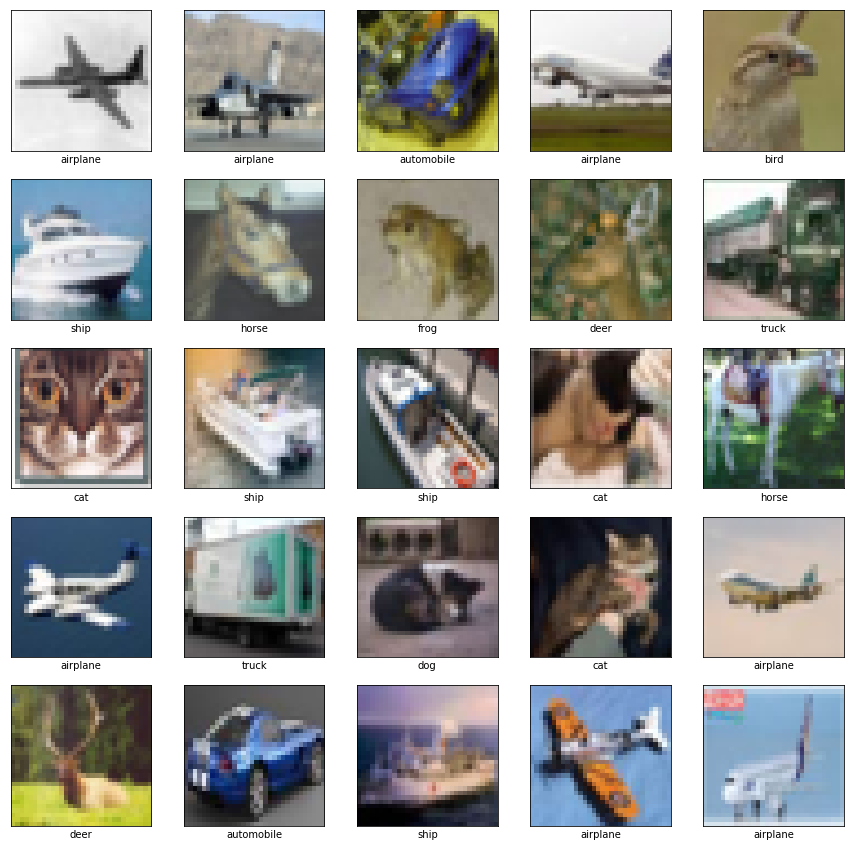

In [5]:
plt.figure(figsize=(15,15))
for i in range(25):
    img_idx = np.random.randint(0, 49999)
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[img_idx])
    plt.xlabel(class_names[np.argmax(train_labels[img_idx])])

## Model Function

In [6]:
from tensorflow.keras.layers import Input, Conv2D, Dense, MaxPool2D, GlobalAveragePooling2D, Concatenate, Dropout

In [7]:
def create_model():
    ## Stem
    inputs = Input(shape=(img_size, img_size, 3))
    net = Conv2D(64, 7, 2, 'SAME', activation='relu')(inputs)
    net = MaxPool2D(3, 2, 'SAME')(net)
    net = Conv2D(64, 1, 1, 'SAME', activation='relu')(net)
    net = Conv2D(192, 3, 1, 'SAME', activation='relu')(net)
    net = MaxPool2D(3, 2, 'SAME')(net)
    ## inception 3a
    b1 = Conv2D(64, 1, 1, 'SAME', activation='relu')(net)
    b2 = Conv2D(96, 1, 1, 'SAME', activation='relu')(net)
    b2 = Conv2D(128, 3, 1, 'SAME', activation='relu')(b2)
    b3 = Conv2D(16, 1, 1, 'SAME', activation='relu')(net)
    b3 = Conv2D(32, 5, 1, 'SAME', activation='relu')(b3)
    b4 = MaxPool2D(3, 1, 'SAME')(net)
    b4 = Conv2D(32, 1, 1, 'SAME', activation='relu')(b4)
    net = Concatenate()([b1, b2, b3, b4])
    ## inception 3b
    b1 = Conv2D(128, 1, 1, 'SAME', activation='relu')(net)
    b2 = Conv2D(128, 1, 1, 'SAME', activation='relu')(net)
    b2 = Conv2D(192, 3, 1, 'SAME', activation='relu')(b2)
    b3 = Conv2D(32, 1, 1, 'SAME', activation='relu')(net)
    b3 = Conv2D(96, 5, 1, 'SAME', activation='relu')(b3)
    b4 = MaxPool2D(3, 1, 'SAME')(net)
    b4 = Conv2D(64, 1, 1, 'SAME', activation='relu')(b4)
    net = Concatenate()([b1, b2, b3, b4])
    ## 
    net = MaxPool2D(3, 2, 'SAME')(net)
    ## inception 4a
    b1 = Conv2D(192, 1, 1, 'SAME', activation='relu')(net)
    b2 = Conv2D(96, 1, 1, 'SAME', activation='relu')(net)
    b2 = Conv2D(208, 3, 1, 'SAME', activation='relu')(b2)
    b3 = Conv2D(16, 1, 1, 'SAME', activation='relu')(net)
    b3 = Conv2D(48, 5, 1, 'SAME', activation='relu')(b3)
    b4 = MaxPool2D(3, 1, 'SAME')(net)
    b4 = Conv2D(64, 1, 1, 'SAME', activation='relu')(b4)
    net = Concatenate()([b1, b2, b3, b4])
    ## inception 4b
    b1 = Conv2D(160, 1, 1, 'SAME', activation='relu')(net)
    b2 = Conv2D(112, 1, 1, 'SAME', activation='relu')(net)
    b2 = Conv2D(224, 3, 1, 'SAME', activation='relu')(b2)
    b3 = Conv2D(24, 1, 1, 'SAME', activation='relu')(net)
    b3 = Conv2D(64, 5, 1, 'SAME', activation='relu')(b3)
    b4 = MaxPool2D(3, 1, 'SAME')(net)
    b4 = Conv2D(64, 1, 1, 'SAME', activation='relu')(b4)
    net = Concatenate()([b1, b2, b3, b4])
    ## inception 4c
    b1 = Conv2D(128, 1, 1, 'SAME', activation='relu')(net)
    b2 = Conv2D(128, 1, 1, 'SAME', activation='relu')(net)
    b2 = Conv2D(256, 3, 1, 'SAME', activation='relu')(b2)
    b3 = Conv2D(24, 1, 1, 'SAME', activation='relu')(net)
    b3 = Conv2D(64, 5, 1, 'SAME', activation='relu')(b3)
    b4 = MaxPool2D(3, 1, 'SAME')(net)
    b4 = Conv2D(64, 1, 1, 'SAME', activation='relu')(b4)
    net = Concatenate()([b1, b2, b3, b4])
    ## inception 4d
    b1 = Conv2D(112, 1, 1, 'SAME', activation='relu')(net)
    b2 = Conv2D(144, 1, 1, 'SAME', activation='relu')(net)
    b2 = Conv2D(288, 3, 1, 'SAME', activation='relu')(b2)
    b3 = Conv2D(32, 1, 1, 'SAME', activation='relu')(net)
    b3 = Conv2D(64, 5, 1, 'SAME', activation='relu')(b3)
    b4 = MaxPool2D(3, 1, 'SAME')(net)
    b4 = Conv2D(64, 1, 1, 'SAME', activation='relu')(b4)
    net = Concatenate()([b1, b2, b3, b4])
    ## inception 4e
    b1 = Conv2D(256, 1, 1, 'SAME', activation='relu')(net)
    b2 = Conv2D(160, 1, 1, 'SAME', activation='relu')(net)
    b2 = Conv2D(320, 3, 1, 'SAME', activation='relu')(b2)
    b3 = Conv2D(32, 1, 1, 'SAME', activation='relu')(net)
    b3 = Conv2D(128, 5, 1, 'SAME', activation='relu')(b3)
    b4 = MaxPool2D(3, 1, 'SAME')(net)
    b4 = Conv2D(128, 1, 1, 'SAME', activation='relu')(b4)
    net = Concatenate()([b1, b2, b3, b4])
    ##
    net = MaxPool2D(3, 2, 'SAME')(net)
    ## inception 5a
    b1 = Conv2D(256, 1, 1, 'SAME', activation='relu')(net)
    b2 = Conv2D(160, 1, 1, 'SAME', activation='relu')(net)
    b2 = Conv2D(320, 3, 1, 'SAME', activation='relu')(b2)
    b3 = Conv2D(32, 1, 1, 'SAME', activation='relu')(net)
    b3 = Conv2D(128, 5, 1, 'SAME', activation='relu')(b3)
    b4 = MaxPool2D(3, 1, 'SAME')(net)
    b4 = Conv2D(128, 1, 1, 'SAME', activation='relu')(b4)
    net = Concatenate()([b1, b2, b3, b4])
    ## inception 5b
    b1 = Conv2D(384, 1, 1, 'SAME', activation='relu')(net)
    b2 = Conv2D(192, 1, 1, 'SAME', activation='relu')(net)
    b2 = Conv2D(384, 3, 1, 'SAME', activation='relu')(b2)
    b3 = Conv2D(48, 1, 1, 'SAME', activation='relu')(net)
    b3 = Conv2D(128, 5, 1, 'SAME', activation='relu')(b3)
    b4 = MaxPool2D(3, 1, 'SAME')(net)
    b4 = Conv2D(128, 1, 1, 'SAME', activation='relu')(b4)
    net = Concatenate()([b1, b2, b3, b4])
    ## global average pooling
    net = GlobalAveragePooling2D()(net)
    net = Dropout(0.4)(net)
    net = Dense(10, activation='softmax')(net)
    
    return keras.Model(inputs=inputs, outputs=net)

In [8]:
model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 56, 56, 64)   4160        max_pooling2d[0][0]              
______________________________________________________________________________________________

## Loss Function

In [9]:
@tf.function
def loss_fn(model, images, labels):
    predictions = model(images, training=True)
    loss = tf.reduce_mean(keras.losses.categorical_crossentropy(labels, predictions))   
    return loss  

## Calculating Gradient & Updating Weights

In [10]:
@tf.function
def train(model, images, labels):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, images, labels)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

## Caculating Model's Accuracy

In [11]:
@tf.function
def evaluate(model, images, labels):
    predictions = model(images, training=False)
    correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))    
    return accuracy

## Optimizer

In [12]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=n_train//batch_size*5,
                                                          decay_rate=0.5,
                                                          staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

## Training

In [13]:
# train my model
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_loss = 0.
    avg_train_acc = 0.
    avg_test_acc = 0.
    train_step = 0
    test_step = 0
    
    for images, labels in train_dataset:
        images = tf.image.resize(images, (img_size, img_size))
        #print(images)
        train(model,images, labels)
        loss = loss_fn(model, images, labels)
        acc = evaluate(model, images, labels)
        avg_loss = avg_loss + loss
        avg_train_acc = avg_train_acc + acc
        train_step += 1
    avg_loss = avg_loss / train_step
    avg_train_acc = avg_train_acc / train_step
    
    for images, labels in test_dataset:
        images = tf.image.resize(images, (img_size, img_size))
        acc = evaluate(model, images, labels)        
        avg_test_acc = avg_test_acc + acc
        test_step += 1    
    avg_test_acc = avg_test_acc / test_step    

    print('Epoch:', '{}'.format(epoch + 1), 'loss =', '{:.8f}'.format(avg_loss), 
          'train accuracy = ', '{:.4f}'.format(avg_train_acc), 
          'test accuracy = ', '{:.4f}'.format(avg_test_acc))


print('Learning Finished!')

Learning started. It takes sometime.
Epoch: 1 loss = 1.74868691 train accuracy =  0.3428 test accuracy =  0.4530
Epoch: 2 loss = 1.28749669 train accuracy =  0.5296 test accuracy =  0.5507
Epoch: 3 loss = 1.02074230 train accuracy =  0.6375 test accuracy =  0.6338
Epoch: 4 loss = 0.85549903 train accuracy =  0.7026 test accuracy =  0.6739
Epoch: 5 loss = 0.72573191 train accuracy =  0.7505 test accuracy =  0.6994
Epoch: 6 loss = 0.62169468 train accuracy =  0.7897 test accuracy =  0.7192
Epoch: 7 loss = 0.52379990 train accuracy =  0.8241 test accuracy =  0.7284
Epoch: 8 loss = 0.43972138 train accuracy =  0.8572 test accuracy =  0.7663
Epoch: 9 loss = 0.36040410 train accuracy =  0.8859 test accuracy =  0.7607
Epoch: 10 loss = 0.30406204 train accuracy =  0.9052 test accuracy =  0.7767
Epoch: 11 loss = 0.25294566 train accuracy =  0.9237 test accuracy =  0.7737
Epoch: 12 loss = 0.21084407 train accuracy =  0.9387 test accuracy =  0.7928
Epoch: 13 loss = 0.17409053 train accuracy =  0.